In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif

In [ ]:
from xgboost import XGBClassifier
from google.colab import files

# Загрузка данных и обработка датасета

In [ ]:
uploaded = files.upload()
dataset1 = pd.read_csv('test-f.csv')

Saving test-f.csv to test-f (2).csv


In [ ]:
uploaded = files.upload()
dataset2 = pd.read_csv('new_test_f.csv')

Saving new_test_f.csv to new_test_f (2).csv


In [ ]:

dataset = pd.concat([dataset1, dataset2], ignore_index=False)
print(f'Размер датасета: {dataset.shape}')
#Смотрим нулевые значения в столбцах
for i in dataset.columns:
    print(f'Столбец: {i}')
    print(f'Количество пропусков: {(dataset.loc[:, i] == 0).sum()}')
    print('-----------------------')


Размер датасета: (11587, 78)
Столбец: result_game
Количество пропусков: 2897
-----------------------
Столбец: count_matches_team1
Количество пропусков: 11
-----------------------
Столбец: count_matches_team2
Количество пропусков: 19
-----------------------
Столбец: winrate_team1
Количество пропусков: 39
-----------------------
Столбец: winrate_team2
Количество пропусков: 27
-----------------------
Столбец: luse_rate_team1
Количество пропусков: 42
-----------------------
Столбец: luse_rate_team2
Количество пропусков: 41
-----------------------
Столбец: drow_rate_team1
Количество пропусков: 18
-----------------------
Столбец: drow_rate_team2
Количество пропусков: 23
-----------------------
Столбец: total_avg_team1_in_match
Количество пропусков: 12
-----------------------
Столбец: total_avg_team2_in_match
Количество пропусков: 19
-----------------------
Столбец: total_avg_team1_toscore
Количество пропусков: 18
-----------------------
Столбец: total_avg_team2_toscore
Количество пропусков: 

In [ ]:
#Удаление бесполезных признаков
del_cols = ["total_avg_corner_team1","total_avg_corner_team2","yelow_cards_ind_total_avg_team1","yelow_cards_ind_total_avg_team2",
            "yelow_cards_oponent_total_avg_team1","yelow_cards_oponent_total_avg_team2", "yelow_cards_total_team1","yelow_cards_total_team2",
           "red_cards_ind_oponent_total_avg_team1","red_cards_ind_oponent_total_avg_team2","red_cards_total_team1", "red_cards_total_team2",
           "foll_ind_total_team1", "foll_ind_total_team2","foll_oponent_total_team1","foll_oponent_total_team2","foll_total_team1","foll_total_team2",]
print(len(del_cols))
dataset = dataset.drop(del_cols, axis = 1)
dataset.shape

18


(11587, 60)

In [ ]:
#Смортим соответсвие count_collision c win_in_collision_team1 и win_in_collision_team2
rows_collision = list((dataset[dataset['count_collision'] < dataset['win_in_collision_team1'] + dataset['win_in_collision_team1']]).index)

dataset = dataset.drop(rows_collision, axis = 0)
dataset.reset_index(drop=True, inplace=True)
print(dataset.shape)

(8362, 60)


In [ ]:
#Заменяем count_collision на drow_collision и вычисляем количество ничьих
dataset.rename(columns={'count_collision': 'drow_collision'}, inplace=True)
for index in range(len(dataset)):
    dataset.loc[index, 'drow_collision'] =  dataset.loc[index, 'drow_collision'] - dataset.loc[index, 'win_in_collision_team1'] - dataset.loc[index, 'win_in_collision_team2']

dataset.head()

,result_game,count_matches_team1,count_matches_team2,winrate_team1,winrate_team2,luse_rate_team1,luse_rate_team2,drow_rate_team1,drow_rate_team2,total_avg_team1_in_match,...,ind_oponent_total_save_team2,save_total_in_match_team1,save_total_in_match_team2,ind_possession_time_team1,ind_possession_time_team2,ind_oponent_possession_time_team1,ind_oponent_possession_time_team2,drow_collision,win_in_collision_team1,win_in_collision_team2
0,0,48,50,41.666667,48.0,18.75,16.0,39.583333,36.0,3.0,...,3.2,7.5,5.8,58,54,42,46,0,1,1
1,-1,50,50,36.000000,24.0,24.00,30.0,40.000000,46.0,3.4,...,3.4,6.1,6.7,54,48,46,52,5,8,4
2,-1,50,50,36.000000,32.0,18.00,22.0,46.000000,46.0,2.6,...,2.8,6.0,6.1,47,52,53,48,2,3,5
3,0,40,50,40.000000,34.0,27.50,18.0,32.500000,48.0,2.4,...,3.5,5.4,12.4,46,44,54,56,2,1,1
4,0,50,50,26.000000,36.0,26.00,16.0,48.000000,48.0,3.2,...,2.8,6.7,5.8,51,47,49,53,0,1,4


In [ ]:
#Проверяем соответсвие count_matches_team1 и count_matches_team2 с drow_collision, win_in_collision_team1, win_in_collision_team2
rows_count = []
for index in range(len(dataset)):
    if dataset.loc[index, 'count_matches_team1'] < dataset.loc[index, 'drow_collision'] + dataset.loc[index, 'win_in_collision_team1'] + dataset.loc[index, 'win_in_collision_team2']:
        rows_count.append(index)
    if dataset.loc[index, 'count_matches_team2'] < dataset.loc[index, 'drow_collision'] + dataset.loc[index, 'win_in_collision_team1'] + dataset.loc[index, 'win_in_collision_team2']:
        rows_count.append(index)
    if dataset.loc[index, 'count_matches_team1'] == 0 or dataset.loc[index, 'count_matches_team2'] == 0:
        rows_count.append(index)
dataset = dataset.drop(rows_count, axis = 0)

In [ ]:
#Удаляем строки с пропущенными значениями

excep_cols= ['drow_collision', 'win_in_collision_team1', 'win_in_collision_team2', 'result_game']
del_rows = []
for i in dataset.columns:
    if i not in excep_cols:
        count = (dataset.loc[:, i] == 0).sum()
        if count > 500:
            for j in dataset[dataset[i] == 0].index:
             del_rows.append(j)
del_rows = list(set(del_rows))
dataset.shape

(8314, 60)

In [ ]:
dataset = dataset.drop(del_rows, axis = 0)

In [ ]:
print(dataset.shape)
dataset.head()

(6614, 60)


,result_game,count_matches_team1,count_matches_team2,winrate_team1,winrate_team2,luse_rate_team1,luse_rate_team2,drow_rate_team1,drow_rate_team2,total_avg_team1_in_match,...,ind_oponent_total_save_team2,save_total_in_match_team1,save_total_in_match_team2,ind_possession_time_team1,ind_possession_time_team2,ind_oponent_possession_time_team1,ind_oponent_possession_time_team2,drow_collision,win_in_collision_team1,win_in_collision_team2
0,0,48,50,41.666667,48.0,18.75,16.0,39.583333,36.0,3.0,...,3.2,7.5,5.8,58,54,42,46,0,1,1
1,-1,50,50,36.000000,24.0,24.00,30.0,40.000000,46.0,3.4,...,3.4,6.1,6.7,54,48,46,52,5,8,4
2,-1,50,50,36.000000,32.0,18.00,22.0,46.000000,46.0,2.6,...,2.8,6.0,6.1,47,52,53,48,2,3,5
3,0,40,50,40.000000,34.0,27.50,18.0,32.500000,48.0,2.4,...,3.5,5.4,12.4,46,44,54,56,2,1,1
4,0,50,50,26.000000,36.0,26.00,16.0,48.000000,48.0,3.2,...,2.8,6.7,5.8,51,47,49,53,0,1,4


In [ ]:
dataset.describe()

,result_game,count_matches_team1,count_matches_team2,winrate_team1,winrate_team2,luse_rate_team1,luse_rate_team2,drow_rate_team1,drow_rate_team2,total_avg_team1_in_match,...,ind_oponent_total_save_team2,save_total_in_match_team1,save_total_in_match_team2,ind_possession_time_team1,ind_possession_time_team2,ind_oponent_possession_time_team1,ind_oponent_possession_time_team2,drow_collision,win_in_collision_team1,win_in_collision_team2
count,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,...,6614.00000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000
mean,0.017690,48.633353,48.932416,33.800486,40.107824,26.034051,24.907971,40.165463,34.984205,2.700348,...,3.95000,7.648397,7.713804,48.884336,50.807378,51.137587,49.213487,3.201693,3.250832,5.151497
std,0.855059,6.432164,5.808799,12.653488,16.377482,6.910472,7.324603,12.220169,14.026157,0.360446,...,5.11282,9.129351,9.367877,4.687780,5.672532,4.686558,5.670745,2.402017,2.687991,3.885169
min,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.50000,2.500000,2.000000,31.000000,25.000000,33.000000,32.000000,0.000000,0.000000,0.000000
25%,-1.000000,50.000000,50.000000,24.000000,28.000000,22.000000,20.000000,32.000000,24.000000,2.400000,...,2.80000,5.700000,5.700000,46.000000,47.000000,48.000000,45.000000,1.000000,1.000000,2.000000
50%,0.000000,50.000000,50.000000,32.000000,36.000000,26.000000,24.000000,42.000000,36.000000,2.700000,...,3.30000,6.400000,6.400000,48.000000,50.000000,52.000000,50.000000,3.000000,3.000000,4.000000
75%,1.000000,50.000000,50.000000,40.000000,52.000000,30.000000,30.000000,48.000000,46.000000,2.900000,...,4.00000,7.500000,7.500000,52.000000,55.000000,54.000000,53.000000,5.000000,5.000000,7.000000
max,1.000000,50.000000,50.000000,86.000000,100.000000,100.000000,50.000000,100.000000,100.000000,5.000000,...,213.00000,296.000000,315.000000,67.000000,68.000000,69.000000,75.000000,13.000000,14.000000,23.000000


In [ ]:
dataset.duplicated().sum()

0

In [ ]:
id_rows = [idx for i in range(1,len(dataset.columns)) for idx in dataset[dataset[dataset.columns[i]] == 0].index]
set(id_rows)
print(1)

1


In [ ]:
dataset.describe()

,result_game,count_matches_team1,count_matches_team2,winrate_team1,winrate_team2,luse_rate_team1,luse_rate_team2,drow_rate_team1,drow_rate_team2,total_avg_team1_in_match,...,ind_oponent_total_save_team2,save_total_in_match_team1,save_total_in_match_team2,ind_possession_time_team1,ind_possession_time_team2,ind_oponent_possession_time_team1,ind_oponent_possession_time_team2,drow_collision,win_in_collision_team1,win_in_collision_team2
count,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,...,6614.00000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000
mean,0.017690,48.633353,48.932416,33.800486,40.107824,26.034051,24.907971,40.165463,34.984205,2.700348,...,3.95000,7.648397,7.713804,48.884336,50.807378,51.137587,49.213487,3.201693,3.250832,5.151497
std,0.855059,6.432164,5.808799,12.653488,16.377482,6.910472,7.324603,12.220169,14.026157,0.360446,...,5.11282,9.129351,9.367877,4.687780,5.672532,4.686558,5.670745,2.402017,2.687991,3.885169
min,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.50000,2.500000,2.000000,31.000000,25.000000,33.000000,32.000000,0.000000,0.000000,0.000000
25%,-1.000000,50.000000,50.000000,24.000000,28.000000,22.000000,20.000000,32.000000,24.000000,2.400000,...,2.80000,5.700000,5.700000,46.000000,47.000000,48.000000,45.000000,1.000000,1.000000,2.000000
50%,0.000000,50.000000,50.000000,32.000000,36.000000,26.000000,24.000000,42.000000,36.000000,2.700000,...,3.30000,6.400000,6.400000,48.000000,50.000000,52.000000,50.000000,3.000000,3.000000,4.000000
75%,1.000000,50.000000,50.000000,40.000000,52.000000,30.000000,30.000000,48.000000,46.000000,2.900000,...,4.00000,7.500000,7.500000,52.000000,55.000000,54.000000,53.000000,5.000000,5.000000,7.000000
max,1.000000,50.000000,50.000000,86.000000,100.000000,100.000000,50.000000,100.000000,100.000000,5.000000,...,213.00000,296.000000,315.000000,67.000000,68.000000,69.000000,75.000000,13.000000,14.000000,23.000000


# Оценка признаков и разделение датасета

In [ ]:
dataset.iloc[:, 1:] = dataset.iloc[:, 1:].replace(0, np.nan)


In [ ]:
# Пример: использование KNN-импутации из библиотеки scikit-learn
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)


In [ ]:
dataset.describe()

,result_game,count_matches_team1,count_matches_team2,winrate_team1,winrate_team2,luse_rate_team1,luse_rate_team2,drow_rate_team1,drow_rate_team2,total_avg_team1_in_match,...,ind_oponent_total_save_team2,save_total_in_match_team1,save_total_in_match_team2,ind_possession_time_team1,ind_possession_time_team2,ind_oponent_possession_time_team1,ind_oponent_possession_time_team2,drow_collision,win_in_collision_team1,win_in_collision_team2
count,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,...,6614.00000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000,6614.000000
mean,0.017690,48.633353,48.932416,33.881714,40.182272,26.075243,24.953266,40.195014,35.042896,2.700794,...,3.95000,7.648397,7.713804,48.884336,50.807378,51.137587,49.213487,3.533066,3.647082,5.343257
std,0.855059,6.432164,5.808799,12.514533,16.259645,6.818770,7.237941,12.182396,14.008490,0.358926,...,5.11282,9.129351,9.367877,4.687780,5.672532,4.686558,5.670745,2.122938,2.388737,3.708373
min,-1.000000,1.000000,1.000000,3.703704,4.166667,4.651163,4.000000,2.000000,2.000000,0.500000,...,0.50000,2.500000,2.000000,31.000000,25.000000,33.000000,32.000000,1.000000,1.000000,1.000000
25%,-1.000000,50.000000,50.000000,24.000000,28.000000,22.000000,20.000000,32.000000,24.000000,2.400000,...,2.80000,5.700000,5.700000,46.000000,47.000000,48.000000,45.000000,2.000000,2.000000,2.000000
50%,0.000000,50.000000,50.000000,32.000000,36.000000,26.000000,24.000000,42.000000,36.000000,2.700000,...,3.30000,6.400000,6.400000,48.000000,50.000000,52.000000,50.000000,3.000000,3.000000,4.000000
75%,1.000000,50.000000,50.000000,40.000000,52.000000,30.000000,30.000000,48.000000,46.000000,2.900000,...,4.00000,7.500000,7.500000,52.000000,55.000000,54.000000,53.000000,5.000000,5.000000,7.000000
max,1.000000,50.000000,50.000000,86.000000,100.000000,100.000000,50.000000,100.000000,100.000000,5.000000,...,213.00000,296.000000,315.000000,67.000000,68.000000,69.000000,75.000000,13.000000,14.000000,23.000000


In [ ]:
X = dataset[dataset.columns[1:].values]
y = dataset[dataset.columns[:1].values]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


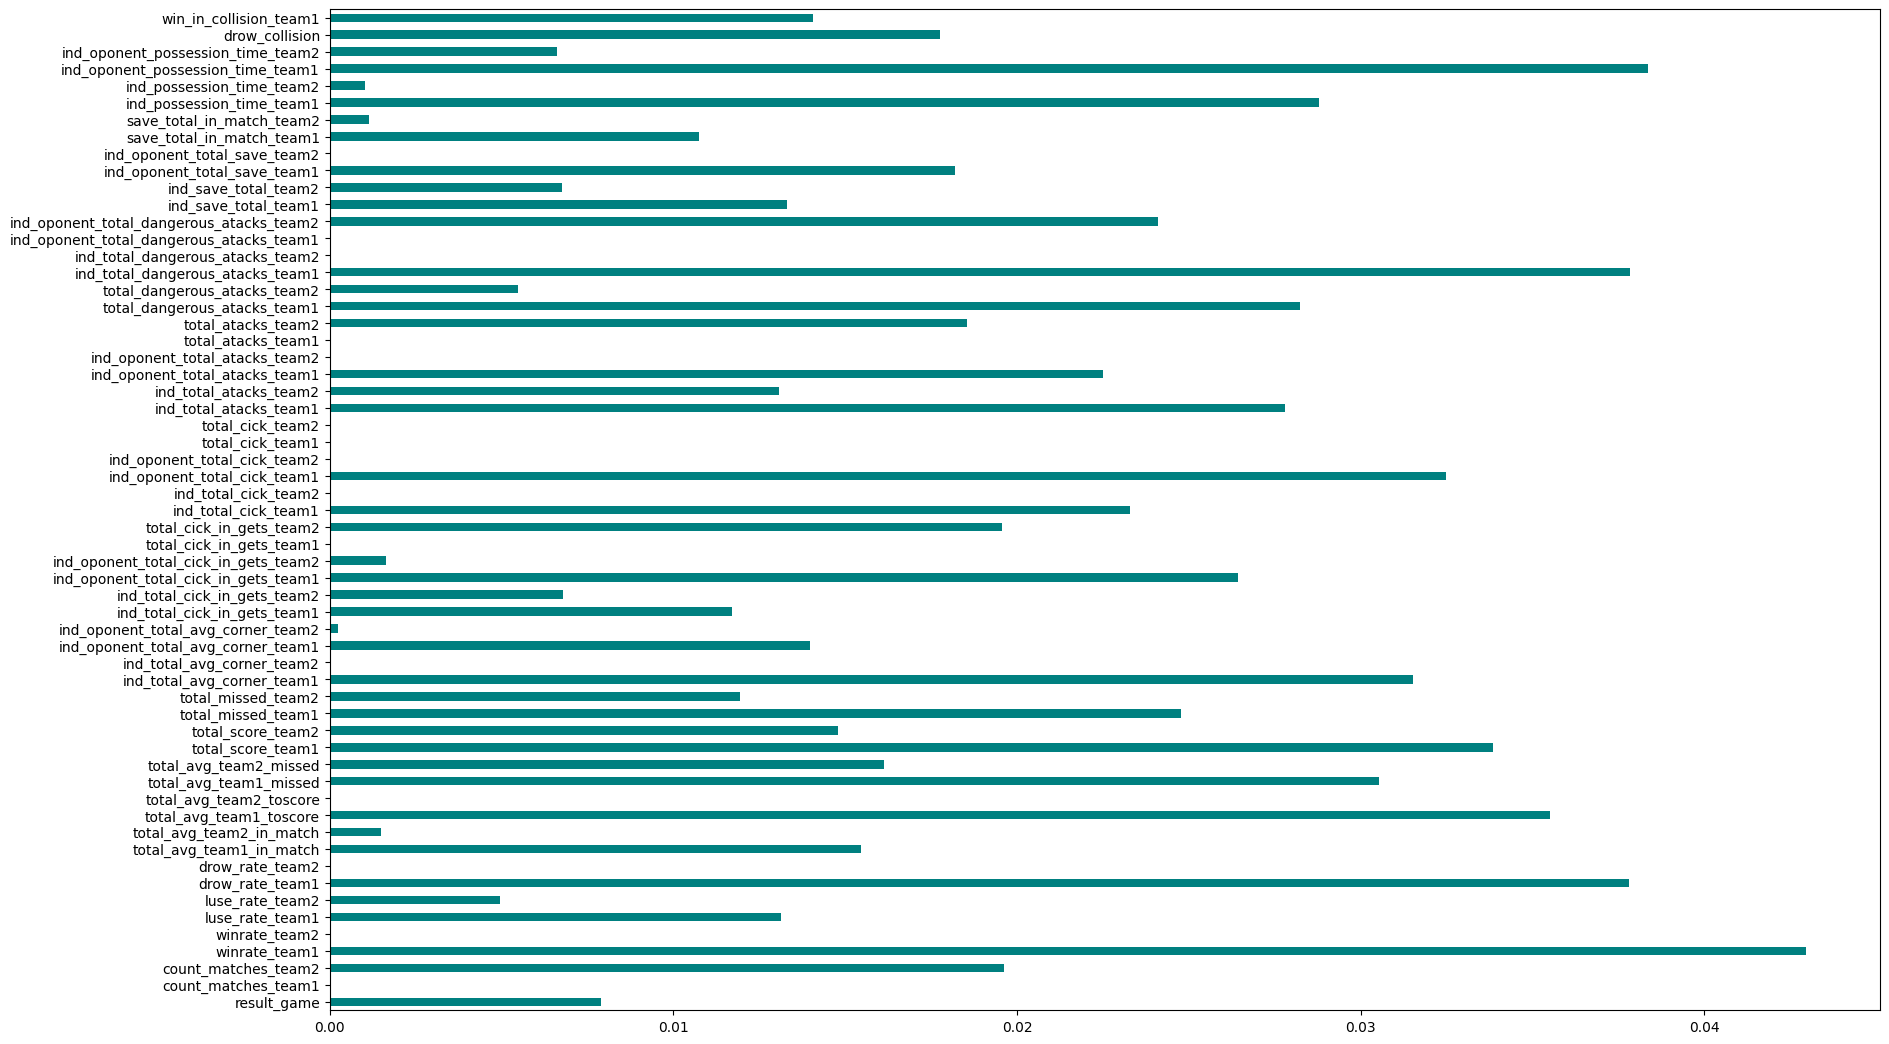

In [ ]:
#Сбор информации
importances = mutual_info_classif(X, y)
plt.figure(figsize=(20,13))
feature_importances = pd.Series(importances, dataset.columns[0:len(dataset.columns)-1])
feature_importances.plot(kind='barh', color='teal')
plt.show()

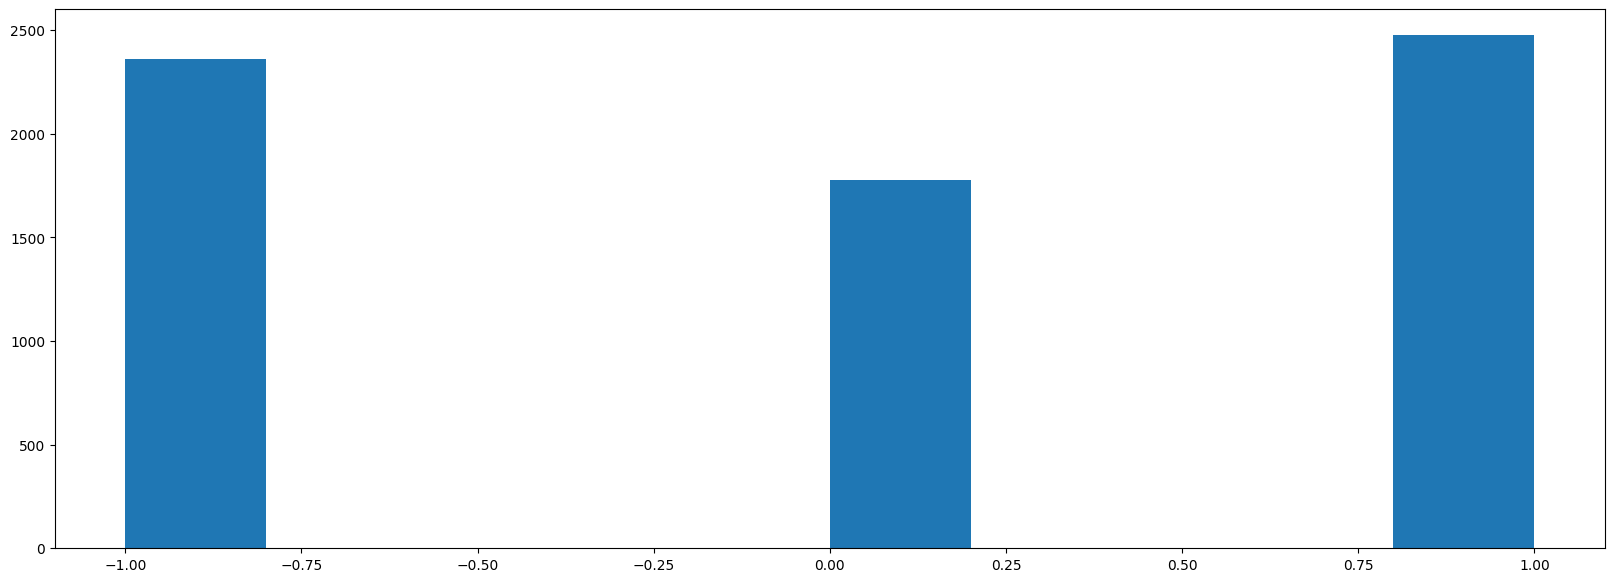

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(dataset[dataset.columns[0]].values)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
y_test

,result_game
3649,-1.0
2299,0.0
3768,-1.0
4914,1.0
5626,1.0
...,...
6468,1.0
1456,0.0
3938,1.0
238,0.0


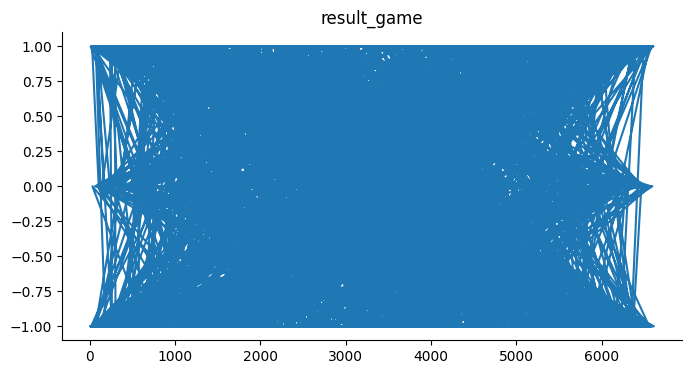

In [ ]:
from matplotlib import pyplot as plt
y_test['result_game'].plot(kind='line', figsize=(8, 4), title='result_game')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Случайный лес с GridSearchCV

In [ ]:
vector_y = y_test['result_game'].reset_index(drop=True)
vector_y

0      -1.0
1       0.0
2      -1.0
3       1.0
4       1.0
       ... 
2178    1.0
2179    0.0
2180    1.0
2181    0.0
2182    1.0
Name: result_game, Length: 2183, dtype: float64

In [ ]:


model_forest = RandomForestClassifier(random_state=42)

param_dist = {'n_estimators': [50, 80, 110, 150, 170, 190, 210],
               'max_features': ['log2', 'sqrt'],
               'max_depth': [2, 4, 5, 6, 7],
               'min_samples_split': [2, 7, 18, 25, 35, 50],
               'min_samples_leaf': [2, 5, 14, 25, 34, 45],
               'bootstrap': [True, False]
             }
print(f'Подбираемые параметры: {param_dist}')
grid_model_forest = GridSearchCV(estimator = model_forest,
                    param_grid = param_dist,
                    scoring='f1_macro',
                    cv=5,
                    verbose = 3,
                    n_jobs=-1,
                   )

Подбираемые параметры: {'n_estimators': [50, 80, 110, 150, 170, 190, 210], 'max_features': ['log2', 'sqrt'], 'max_depth': [2, 4, 5, 6, 7], 'min_samples_split': [2, 7, 18, 25, 35, 50], 'min_samples_leaf': [2, 5, 14, 25, 34, 45], 'bootstrap': [True, False]}


In [ ]:
start = time.time()
grid_model_forest.fit(X_train, y_train.values.ravel())
end = time.time()

Fitting 5 folds for each of 5040 candidates, totalling 25200 fits


In [ ]:
#Сведения об обучении
print(f"Время обучения: {end - start}")
print("Лучшие парметры случайного леса")
print(grid_model_forest.best_params_)
class_labels = grid_model_forest.classes_
print(f"Классы предсказаний: {class_labels}")
print('---------------')

#Оценка качества
y_pred_forest = grid_model_forest.predict(X_test)
print('F1-macro: ', f1_score(y_test, y_pred_forest, average='macro'))
print('Accuracy: ',accuracy_score(y_test, y_pred_forest))
print('Оценка качества по классам')
for target_class in [-1,0,1]:
    binary_predictions = []
    for ans in range(len(vector_y)):
        if vector_y[ans] == target_class:
            binary_predictions.append(1 if y_pred_forest[ans] == vector_y[ans] else 0)
    accuracy = accuracy_score(binary_predictions, [1]*len(binary_predictions))
    print(f"Точность определения класса {target_class}: {accuracy}")

Время обучения: 1031.8230237960815
Лучшие парметры случайного леса
{'bootstrap': False, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Классы предсказаний: [-1  0  1]
---------------
F1-macro:  0.39114095764530665
Accuracy:  0.49500998003992014
Оценка качества по классам
Точность определения класса -1: 0.5542857142857143
Точность определения класса 0: 0.03278688524590164
Точность определения класса 1: 0.7205882352941176


# Генерация данных

In [ ]:
# Пример: использование KNN-импутации из библиотеки scikit-learn
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
dataset= pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)


NameError: name 'pd' is not defined

In [ ]:
type_zero = dataset[dataset['result_game'] == 0]
type_m1 = dataset[dataset['result_game'] == -1]
type_m2 = dataset[dataset['result_game'] == 1]
type_mul_zero = type_zero.shape[0] / (type_m1.shape[0] + type_m2.shape[0])
print(dataset[dataset['result_game'] == 0].shape)
print(type_mul_zero)
print(dataset.shape)
dataset = pd.concat((dataset, dataset[dataset['result_game'] == 0].iloc[np.arange(int(len(dataset[dataset['result_game'] == 0]) * (type_mul_zero)))]))
print(dataset.shape)
dataset[dataset['result_game'] == 0].shape

(3648, 60)
0.7541864792226587
(8485, 60)
(11236, 60)


(6399, 60)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

# Предположим, у вас есть обучающие данные X_train и метки классов y_train
# Создадим синтетические данные для увеличения редкого класса
smote = SMOTE(sampling_strategy={-1:4500, 0:6000, 1:5000}, random_state=50)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# X_train_resampled и y_train_resampled теперь содержат синтетически созданные примеры
model_forest = RandomForestClassifier( random_state=42)

9249
9249


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
start = time.time()
model_forest.fit(X_train_resampled, y_train_resampled)
end = time.time()

<ipython-input-207-bb39fad630b0>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_forest.fit(X_train_resampled, y_train_resampled)


In [ ]:
feature_importances = model_forest.feature_importances_
feature_importances
plt.bar(X.columns, feature_importances)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.figure(figsize=(20,30))
plt.show()

NameError: name 'model_forest' is not defined

In [ ]:
y_pred_forest = model_forest.predict(X_test)
print('F1-macro: ', f1_score(y_test, y_pred_forest, average='macro'))
print('Accuracy: ',accuracy_score(y_test, y_pred_forest))
print('Оценка качества по классам')
for target_class in [-1,0,1]:
    binary_predictions = []
    for ans in range(len(vector_y)):
        if vector_y[ans] == target_class:
            binary_predictions.append(1 if y_pred_forest[ans] == vector_y[ans] else 0)
    accuracy = accuracy_score(binary_predictions, [1]*len(binary_predictions))
    print(f"Точность определения класса {target_class}: {accuracy}")

F1-macro:  0.45292971494251755
Accuracy:  0.4665271966527197
Оценка качества по классам
Точность определения класса -1: 0.38720262510254305
Точность определения класса 0: 0.40641158221303
Точность определения класса 1: 0.561050061050061


# Cоздание модели для определения ничьих


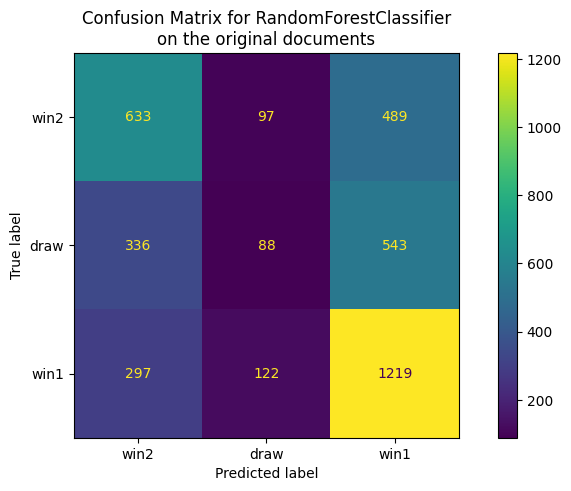

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_forest, ax=ax)
ax.xaxis.set_ticklabels(["win2","draw","win1"])
ax.yaxis.set_ticklabels(["win2","draw","win1"])
_ = ax.set_title(
    f"Confusion Matrix for {model_forest.__class__.__name__}\non the original documents"
)

In [ ]:
def changng_y(y):
    test_idex_xy=np.where(y!=0)[0]
    y_train__zero=[]
    for index in range(len(y)):
        changing_index=0
        if index  in test_idex_xy:
            changing_index=1
        y_train__zero.append(changing_index)
    return y_train__zero

In [ ]:
y_train_zero,y_test_zero=changng_y(y_train_resampled),changng_y(y_test)

In [ ]:
model_forest = RandomForestClassifier(random_state=42)
model_XGB =XGBClassifier(
    objective= 'binary:logistic',
    seed = 42
)
model_forest.fit(X_train_resampled, y_train_zero)



RandomForestClassifier(random_state=42)

In [ ]:
y_pred_forest = model_forest.predict(X_test)
print('F1-macro: ', f1_score(y_test_zero, y_pred_forest, average="macro"))
print('Accuracy: ',accuracy_score(y_test_zero, y_pred_forest))
print('Оценка качества по классам')
for target_class in [0,1]:
    binary_predictions = []
    for ans in range(len(vector_y)):
        if vector_y[ans] == target_class:
            binary_predictions.append(1 if y_pred_forest[ans] == vector_y[ans] else 0)
    accuracy = accuracy_score(binary_predictions, [1]*len(binary_predictions))
    print(f"Точность определения класса {target_class}: {accuracy}")


F1-macro:  0.5205049720559795
Accuracy:  0.6101694915254238
Оценка качества по классам
Точность определения класса 0: 0.32605042016806723
Точность определения класса 1: 0.676962676962677


# Градиентный бустинг с GridSearchCV

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_xgboost = le.fit_transform(y_train.values.ravel())

In [ ]:
model_xgboost = XGBClassifier(
    objective= 'multi:softmax',
    nthread=3,
    seed = 42
)
parameters_xgboost = {
    'max_depth': range (2, 9, 1),
    'n_estimators': range(60, 180, 40),
    'learning_rate': [0.1, 0.05, 0.055],
    'reg_lambda' : [1,2,3,4],
    'reg_alpha' : [1,2,3,4]
}
grid_search_xgboost = GridSearchCV(
    estimator=model_xgboost,
    param_grid=parameters_xgboost,
    scoring = 'f1_macro',
    n_jobs = 3,
    cv = 10,
    verbose=3
)

In [ ]:
start = time.time()
grid_search_xgboost.fit(X_train, y_train_xgboost)
end = time.time()


Fitting 10 folds for each of 1008 candidates, totalling 10080 fits


In [ ]:
#Сведения об обучении
print(f"Время обучения: {end-start}")
print("Лучшие параметры модели: ")
print(grid_search_xgboost.best_params_)

#Оценка качества
y_pred_xgboost = grid_search_xgboost.predict(X_test)
for i in range(len(y_pred_xgboost)):
    y_pred_xgboost[i]-=1
print('---------------')
print('F1-macro: ',f1_score(y_test, y_pred_xgboost, average='macro'))
print('Accuracy: ',accuracy_score(y_test, y_pred_xgboost))
print('Оценка качества по классам')
for target_class in [-1,0,1]:
    binary_predictions = []
    for ans in range(len(vector_y)):
        if vector_y[ans] == target_class:
            binary_predictions.append(1 if y_pred_xgboost[ans] == vector_y[ans] else 0)
    accuracy = accuracy_score(binary_predictions, [1]*len(binary_predictions))
    print(f"Точность определения класса {target_class}: {accuracy}")

Время обучения: 2263.8572402000427
Лучшие параметры модели: 
{'learning_rate': 0.055, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 2, 'reg_lambda': 1}
---------------
F1-macro:  0.4025092082618949
Accuracy:  0.4810379241516966
Оценка качества по классам
Точность определения класса -1: 0.5428571428571428
Точность определения класса 0: 0.07377049180327869
Точность определения класса 1: 0.6715686274509803


In [ ]:
y_test.head()

# Нейронная сеть

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm.notebook import tqdm
from datetime import datetime

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train.values.ravel())
#Разделение датасета на valid и train
X_Train, X_Val, y_Train, y_Val = train_test_split(X_train, y_train_le, test_size=0.2, random_state=42)
#Преобразование в tensor
X_train_t = F.normalize(torch.tensor(X_Train.to_numpy(), dtype=torch.float32), p=2, dim=1)
X_val_t = F.normalize(torch.tensor(X_Val.to_numpy(), dtype=torch.float32), p=2, dim=1)
y_train_t = torch.tensor(y_Train, dtype=torch.long)
y_val_t = torch.tensor(y_Val, dtype=torch.long)

In [ ]:
#Создание датасета
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [ ]:
#Класс нейронной сети
class Football_net(nn.Module):
  def __init__(self):
    super(Football_net, self).__init__()
    self.fc1 = nn.Linear(59, 35)
    self.fc2 = nn.Linear(35, 20)
    #self.fc3 = nn.Linear(20, 10)
    self.fc3 = nn.Linear(20, 3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    #x = F.relu(self.fc3(x))
    x = self.fc3(x)
    return x

In [ ]:
model = Football_net()
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters())

In [ ]:
loaders = {"train": train_dataloader, "valid": val_dataloader}

max_epochs = 50
accuracy = {'train' : [], 'valid' : []}
train_losses = []
valid_losses = []
epoch_erly_stopping = 0
flag = False
col_not_best = 0
last_loss = np.Inf
best_model = model
start_time = datetime.now()

for epoch in tqdm(range(max_epochs)):

    for k, dataloader in loaders.items():
        epochs_correct = 0
        epochs_all = 0
        for x_batch, y_batch in (pbar := tqdm(dataloader)):
          if k == 'train':
            model.train()
            optimiser.zero_grad()
            outp = model(x_batch)
          else:
            model.eval()
            with torch.no_grad():
              outp = model(x_batch)
          _, pred_class = torch.max(outp, dim=1)
          correct = (pred_class == y_batch).sum()
          alls = len(x_batch)
          epochs_correct += correct.item()
          epochs_all += alls
          loss = criterion(outp, y_batch)
          if k == 'train':
            train_losses.append(loss.item())
            loss.backward()
            optimiser.step()
          else:
            valid_losses.append(loss.item())
        if k == 'valid':
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            print(f"[{epoch:>3}/{max_epochs:>3}] loss_train: {train_loss:.5f} | loss_valid: {valid_loss:.5f}")

            if last_loss > valid_loss:
                col_not_best = 0
                epoch_erly_stopping = epoch
                best_model = model
                last_loss = valid_loss
            else:
                if col_not_best >= 20:
                    print("Stop")
                    accuracy[k].append(epochs_correct/epochs_all)
                    flag = True
                    break
                else:
                    col_not_best += 1
        print(f"Loader: {k}. Accuracy: {epochs_correct/epochs_all}")
        accuracy[k].append(epochs_correct/epochs_all)
    if flag:
        break
print(f'Program execution time: {datetime.now() - start_time}')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.3866935483870968


  0%|          | 0/49 [00:00<?, ?it/s]

[  0/ 50] loss_train: 1.09041 | loss_valid: 1.08727
Loader: valid. Accuracy: 0.38870967741935486


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4081451612903226


  0%|          | 0/49 [00:00<?, ?it/s]

[  1/ 50] loss_train: 1.08010 | loss_valid: 1.06745
Loader: valid. Accuracy: 0.4535483870967742


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.45225806451612904


  0%|          | 0/49 [00:00<?, ?it/s]

[  2/ 50] loss_train: 1.06511 | loss_valid: 1.05773
Loader: valid. Accuracy: 0.4474193548387097


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4588709677419355


  0%|          | 0/49 [00:00<?, ?it/s]

[  3/ 50] loss_train: 1.05603 | loss_valid: 1.05235
Loader: valid. Accuracy: 0.4461290322580645


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4586290322580645


  0%|          | 0/49 [00:00<?, ?it/s]

[  4/ 50] loss_train: 1.05035 | loss_valid: 1.04901
Loader: valid. Accuracy: 0.4432258064516129


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.45564516129032256


  0%|          | 0/49 [00:00<?, ?it/s]

[  5/ 50] loss_train: 1.04675 | loss_valid: 1.04666
Loader: valid. Accuracy: 0.4364516129032258


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4568548387096774


  0%|          | 0/49 [00:00<?, ?it/s]

[  6/ 50] loss_train: 1.04379 | loss_valid: 1.04540
Loader: valid. Accuracy: 0.44548387096774195


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4569354838709677


  0%|          | 0/49 [00:00<?, ?it/s]

[  7/ 50] loss_train: 1.04165 | loss_valid: 1.04379
Loader: valid. Accuracy: 0.45903225806451614


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4600806451612903


  0%|          | 0/49 [00:00<?, ?it/s]

[  8/ 50] loss_train: 1.03975 | loss_valid: 1.04285
Loader: valid. Accuracy: 0.44548387096774195


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.46153225806451614


  0%|          | 0/49 [00:00<?, ?it/s]

[  9/ 50] loss_train: 1.03818 | loss_valid: 1.04195
Loader: valid. Accuracy: 0.4570967741935484


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4611290322580645


  0%|          | 0/49 [00:00<?, ?it/s]

[ 10/ 50] loss_train: 1.03693 | loss_valid: 1.04099
Loader: valid. Accuracy: 0.4503225806451613


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4654032258064516


  0%|          | 0/49 [00:00<?, ?it/s]

[ 11/ 50] loss_train: 1.03581 | loss_valid: 1.04015
Loader: valid. Accuracy: 0.457741935483871


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4660483870967742


  0%|          | 0/49 [00:00<?, ?it/s]

[ 12/ 50] loss_train: 1.03484 | loss_valid: 1.03955
Loader: valid. Accuracy: 0.4625806451612903


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4695967741935484


  0%|          | 0/49 [00:00<?, ?it/s]

[ 13/ 50] loss_train: 1.03396 | loss_valid: 1.03892
Loader: valid. Accuracy: 0.45903225806451614


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4678225806451613


  0%|          | 0/49 [00:00<?, ?it/s]

[ 14/ 50] loss_train: 1.03317 | loss_valid: 1.03853
Loader: valid. Accuracy: 0.45548387096774196


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4688709677419355


  0%|          | 0/49 [00:00<?, ?it/s]

[ 15/ 50] loss_train: 1.03247 | loss_valid: 1.03800
Loader: valid. Accuracy: 0.4603225806451613


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4720967741935484


  0%|          | 0/49 [00:00<?, ?it/s]

[ 16/ 50] loss_train: 1.03187 | loss_valid: 1.03753
Loader: valid. Accuracy: 0.457741935483871


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4737903225806452


  0%|          | 0/49 [00:00<?, ?it/s]

[ 17/ 50] loss_train: 1.03130 | loss_valid: 1.03713
Loader: valid. Accuracy: 0.45741935483870966


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.46911290322580645


  0%|          | 0/49 [00:00<?, ?it/s]

[ 18/ 50] loss_train: 1.03073 | loss_valid: 1.03675
Loader: valid. Accuracy: 0.46


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47483870967741937


  0%|          | 0/49 [00:00<?, ?it/s]

[ 19/ 50] loss_train: 1.03025 | loss_valid: 1.03638
Loader: valid. Accuracy: 0.4625806451612903


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47080645161290324


  0%|          | 0/49 [00:00<?, ?it/s]

[ 20/ 50] loss_train: 1.02980 | loss_valid: 1.03604
Loader: valid. Accuracy: 0.4632258064516129


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4729838709677419


  0%|          | 0/49 [00:00<?, ?it/s]

[ 21/ 50] loss_train: 1.02936 | loss_valid: 1.03571
Loader: valid. Accuracy: 0.46161290322580645


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4718548387096774


  0%|          | 0/49 [00:00<?, ?it/s]

[ 22/ 50] loss_train: 1.02898 | loss_valid: 1.03543
Loader: valid. Accuracy: 0.4612903225806452


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47338709677419355


  0%|          | 0/49 [00:00<?, ?it/s]

[ 23/ 50] loss_train: 1.02862 | loss_valid: 1.03539
Loader: valid. Accuracy: 0.4625806451612903


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4696774193548387


  0%|          | 0/49 [00:00<?, ?it/s]

[ 24/ 50] loss_train: 1.02830 | loss_valid: 1.03513
Loader: valid. Accuracy: 0.4664516129032258


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4713709677419355


  0%|          | 0/49 [00:00<?, ?it/s]

[ 25/ 50] loss_train: 1.02793 | loss_valid: 1.03491
Loader: valid. Accuracy: 0.4635483870967742


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47403225806451615


  0%|          | 0/49 [00:00<?, ?it/s]

[ 26/ 50] loss_train: 1.02762 | loss_valid: 1.03470
Loader: valid. Accuracy: 0.4587096774193548


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4745967741935484


  0%|          | 0/49 [00:00<?, ?it/s]

[ 27/ 50] loss_train: 1.02731 | loss_valid: 1.03449
Loader: valid. Accuracy: 0.46419354838709675


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4735483870967742


  0%|          | 0/49 [00:00<?, ?it/s]

[ 28/ 50] loss_train: 1.02703 | loss_valid: 1.03438
Loader: valid. Accuracy: 0.45645161290322583


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4739516129032258


  0%|          | 0/49 [00:00<?, ?it/s]

[ 29/ 50] loss_train: 1.02677 | loss_valid: 1.03418
Loader: valid. Accuracy: 0.4638709677419355


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4736290322580645


  0%|          | 0/49 [00:00<?, ?it/s]

[ 30/ 50] loss_train: 1.02650 | loss_valid: 1.03406
Loader: valid. Accuracy: 0.4632258064516129


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47346774193548385


  0%|          | 0/49 [00:00<?, ?it/s]

[ 31/ 50] loss_train: 1.02627 | loss_valid: 1.03386
Loader: valid. Accuracy: 0.46064516129032257


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4732258064516129


  0%|          | 0/49 [00:00<?, ?it/s]

[ 32/ 50] loss_train: 1.02603 | loss_valid: 1.03373
Loader: valid. Accuracy: 0.46419354838709675


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47483870967741937


  0%|          | 0/49 [00:00<?, ?it/s]

[ 33/ 50] loss_train: 1.02581 | loss_valid: 1.03363
Loader: valid. Accuracy: 0.4551612903225806


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47524193548387095


  0%|          | 0/49 [00:00<?, ?it/s]

[ 34/ 50] loss_train: 1.02560 | loss_valid: 1.03355
Loader: valid. Accuracy: 0.4570967741935484


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47161290322580646


  0%|          | 0/49 [00:00<?, ?it/s]

[ 35/ 50] loss_train: 1.02540 | loss_valid: 1.03343
Loader: valid. Accuracy: 0.4619354838709677


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4754032258064516


  0%|          | 0/49 [00:00<?, ?it/s]

[ 36/ 50] loss_train: 1.02522 | loss_valid: 1.03330
Loader: valid. Accuracy: 0.46096774193548384


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47516129032258064


  0%|          | 0/49 [00:00<?, ?it/s]

[ 37/ 50] loss_train: 1.02504 | loss_valid: 1.03320
Loader: valid. Accuracy: 0.4587096774193548


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47677419354838707


  0%|          | 0/49 [00:00<?, ?it/s]

[ 38/ 50] loss_train: 1.02485 | loss_valid: 1.03306
Loader: valid. Accuracy: 0.4654838709677419


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47258064516129034


  0%|          | 0/49 [00:00<?, ?it/s]

[ 39/ 50] loss_train: 1.02466 | loss_valid: 1.03306
Loader: valid. Accuracy: 0.4529032258064516


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4755645161290323


  0%|          | 0/49 [00:00<?, ?it/s]

[ 40/ 50] loss_train: 1.02446 | loss_valid: 1.03303
Loader: valid. Accuracy: 0.4551612903225806


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4764516129032258


  0%|          | 0/49 [00:00<?, ?it/s]

[ 41/ 50] loss_train: 1.02430 | loss_valid: 1.03289
Loader: valid. Accuracy: 0.4625806451612903


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47653225806451616


  0%|          | 0/49 [00:00<?, ?it/s]

[ 42/ 50] loss_train: 1.02412 | loss_valid: 1.03278
Loader: valid. Accuracy: 0.46483870967741936


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47733870967741937


  0%|          | 0/49 [00:00<?, ?it/s]

[ 43/ 50] loss_train: 1.02393 | loss_valid: 1.03265
Loader: valid. Accuracy: 0.4661290322580645


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47451612903225804


  0%|          | 0/49 [00:00<?, ?it/s]

[ 44/ 50] loss_train: 1.02378 | loss_valid: 1.03257
Loader: valid. Accuracy: 0.45645161290322583


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4787903225806452


  0%|          | 0/49 [00:00<?, ?it/s]

[ 45/ 50] loss_train: 1.02362 | loss_valid: 1.03246
Loader: valid. Accuracy: 0.4629032258064516


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4785483870967742


  0%|          | 0/49 [00:00<?, ?it/s]

[ 46/ 50] loss_train: 1.02345 | loss_valid: 1.03239
Loader: valid. Accuracy: 0.4654838709677419


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.47258064516129034


  0%|          | 0/49 [00:00<?, ?it/s]

[ 47/ 50] loss_train: 1.02330 | loss_valid: 1.03227
Loader: valid. Accuracy: 0.4632258064516129


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4780645161290323


  0%|          | 0/49 [00:00<?, ?it/s]

[ 48/ 50] loss_train: 1.02314 | loss_valid: 1.03216
Loader: valid. Accuracy: 0.46516129032258063


  0%|          | 0/194 [00:00<?, ?it/s]

Loader: train. Accuracy: 0.4798387096774194


  0%|          | 0/49 [00:00<?, ?it/s]

[ 49/ 50] loss_train: 1.02298 | loss_valid: 1.03206
Loader: valid. Accuracy: 0.45806451612903226
Program execution time: 0:00:43.414916


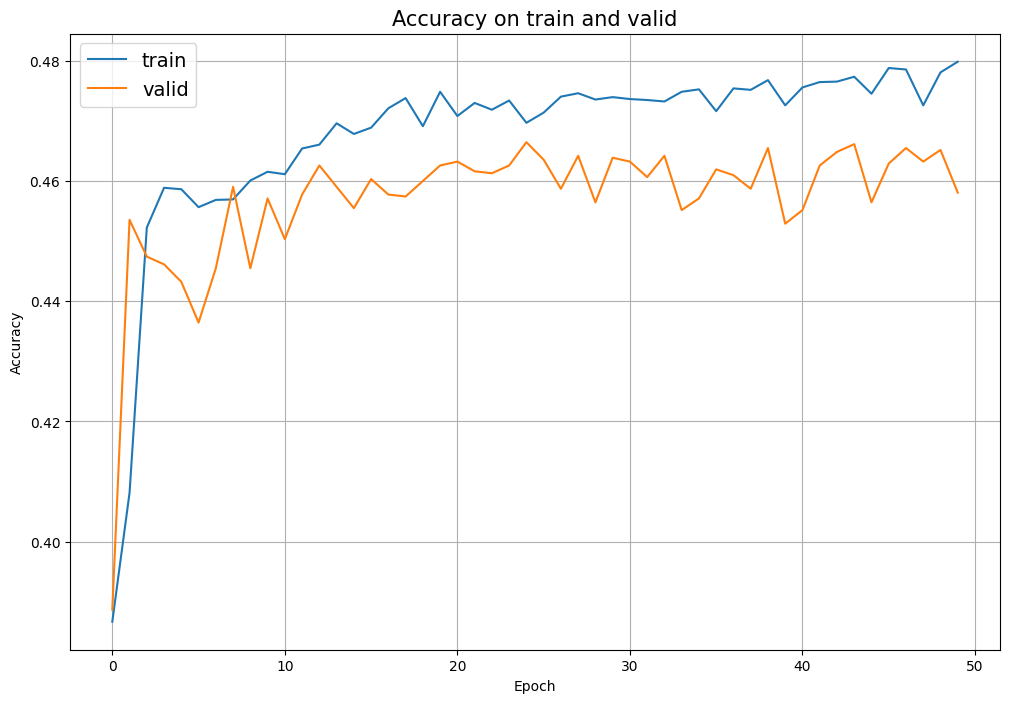

In [ ]:
train_acurs = accuracy['train']
val_acurs = accuracy['valid']

plt.figure(figsize=(12, 8))
plt.plot(train_acurs, label='train')
plt.plot(val_acurs, label='valid')
plt.title('Accuracy on train and valid', fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
X_test_t = F.normalize(torch.tensor(X_test.to_numpy(), dtype=torch.float32), p=2, dim=1)
with torch.no_grad():
  best_model.eval()
  outp = best_model(X_test_t)
preds = outp.argmax(-1)
y_pred_nn = preds.tolist()

In [ ]:
#Оценка качества
for i in range(len(y_pred_nn)):
    y_pred_nn[i]-=1
print('---------------')
print('F1-macro: ',f1_score(y_test, y_pred_nn, average='macro'))
print('Accuracy: ',accuracy_score(y_test, y_pred_nn))
print('Оценка качества по классам')
for target_class in [-1,0,1]:
    binary_predictions = []
    for ans in range(len(vector_y)):
        if vector_y[ans] == target_class:
            binary_predictions.append(1 if y_pred_nn[ans] == vector_y[ans] else 0)
    accuracy = accuracy_score(binary_predictions, [1]*len(binary_predictions))
    print(f"Точность определения класса {target_class}: {accuracy}")

---------------
F1-macro:  0.023739837398373986
Accuracy:  0.03344021988089785
Оценка качества по классам
Точность определения класса -1: 0.09001233045622688
Точность определения класса 0: 0.0
Точность определения класса 1: 0.0


# Фигня

In [ ]:
feature_importance = grid_search_xgboost.best_estimator_.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

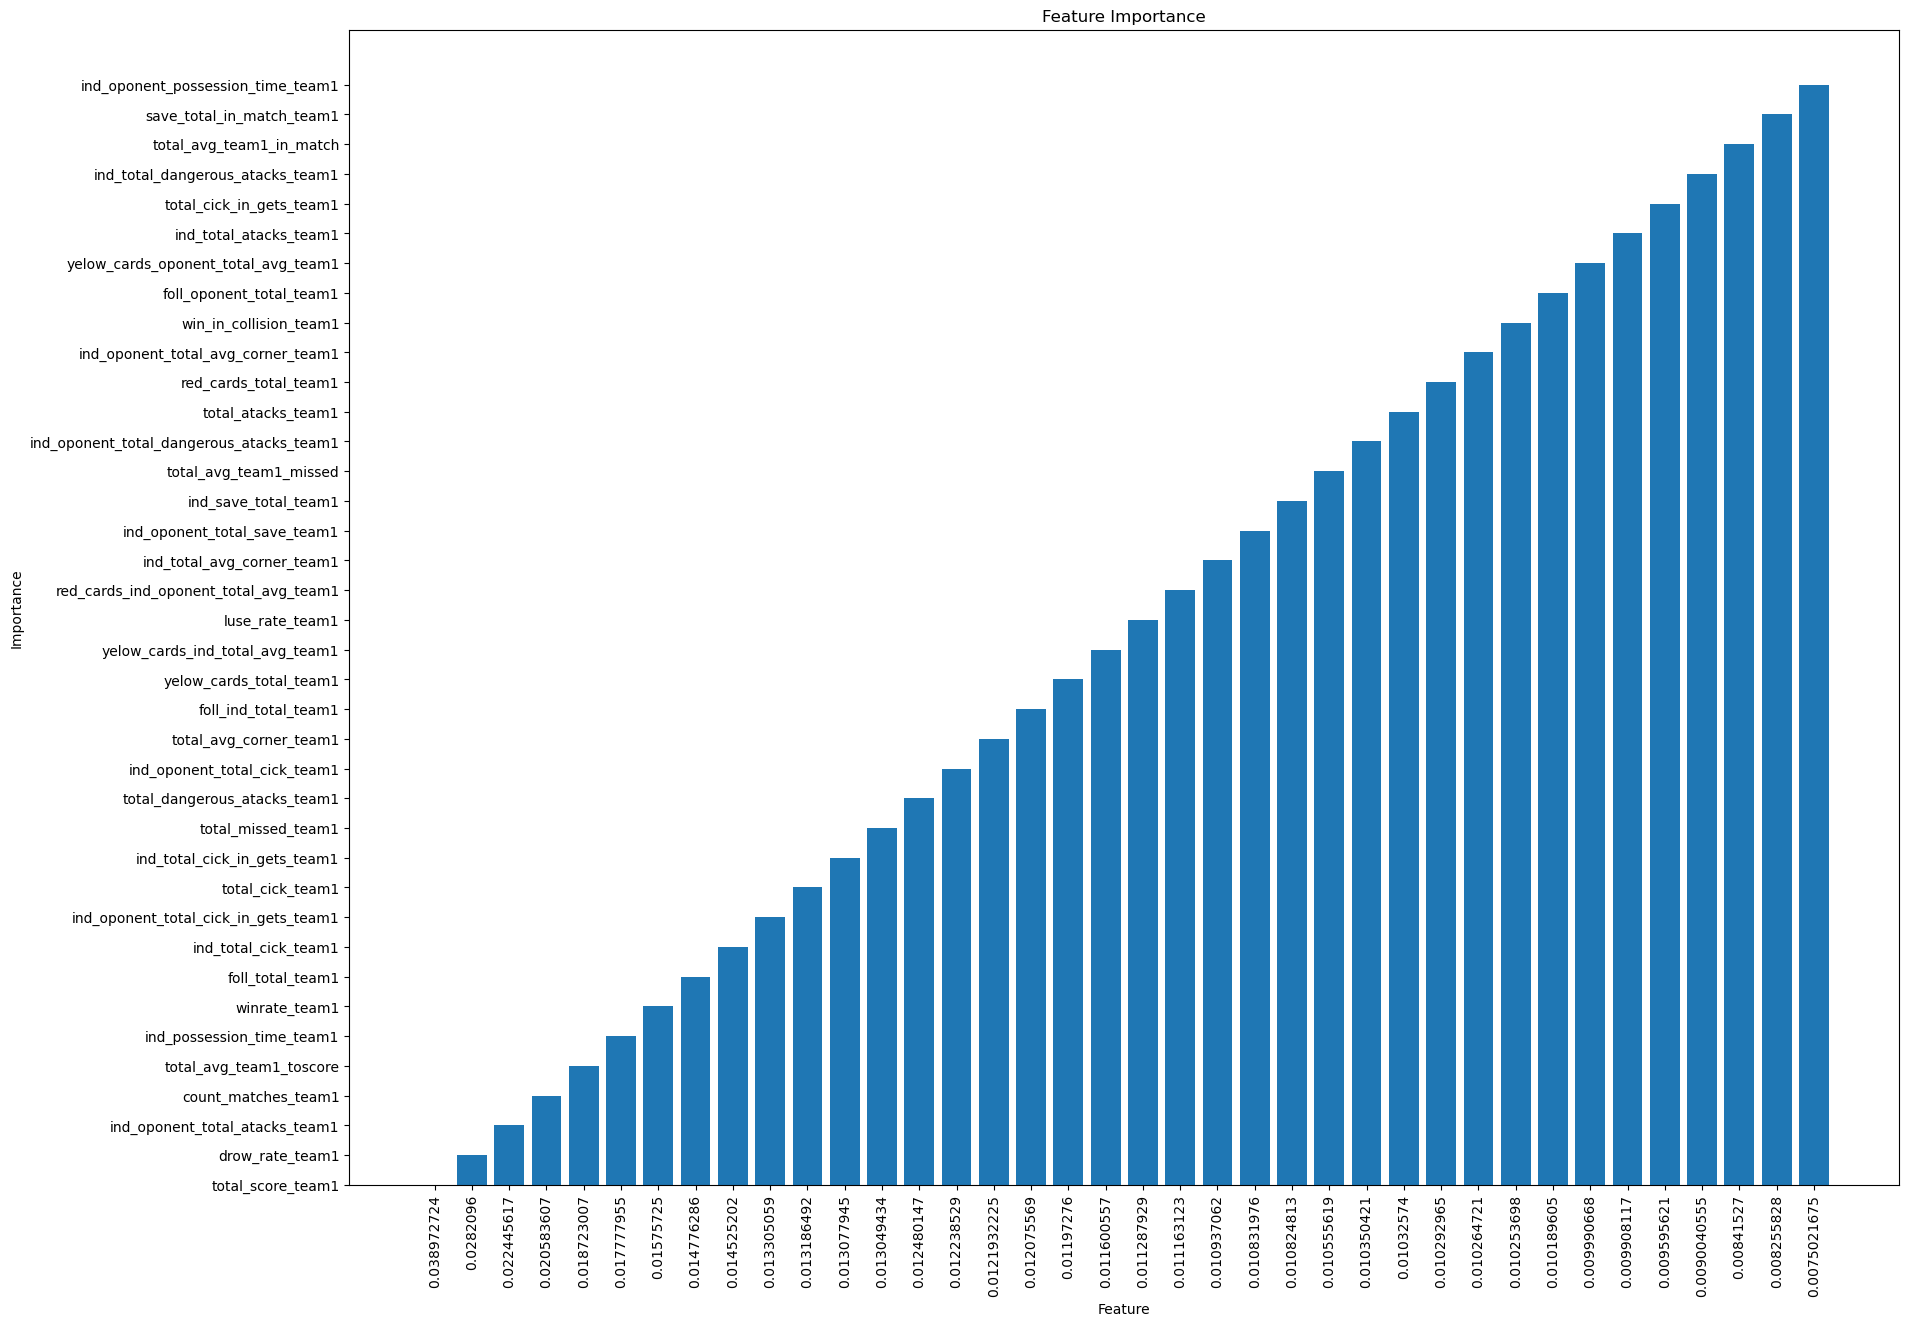

In [ ]:
sorted_feature_names = feature_importance[sorted_idx]
sorted_feature_importance = X_train.columns[sorted_idx]

sorted_feature_importance1 =[]
sorted_feature_importance2 = []
sorted_feature_names1 = []
sorted_feature_names2 = []
for i in range(len(sorted_feature_importance)):
    if '1' in sorted_feature_importance[i]:
        sorted_feature_importance1.append(sorted_feature_importance[i])
        sorted_feature_names1.append(sorted_feature_names[i])
    if '2' in sorted_feature_importance[i]:
        sorted_feature_importance2.append(sorted_feature_importance[i])
        sorted_feature_names2.append(sorted_feature_names[i])


plt.figure(figsize=(20, 15))
plt.bar(range(len(sorted_feature_importance1)), sorted_feature_importance1, align="center")
plt.xticks(range(len(sorted_feature_importance1)), sorted_feature_names1, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

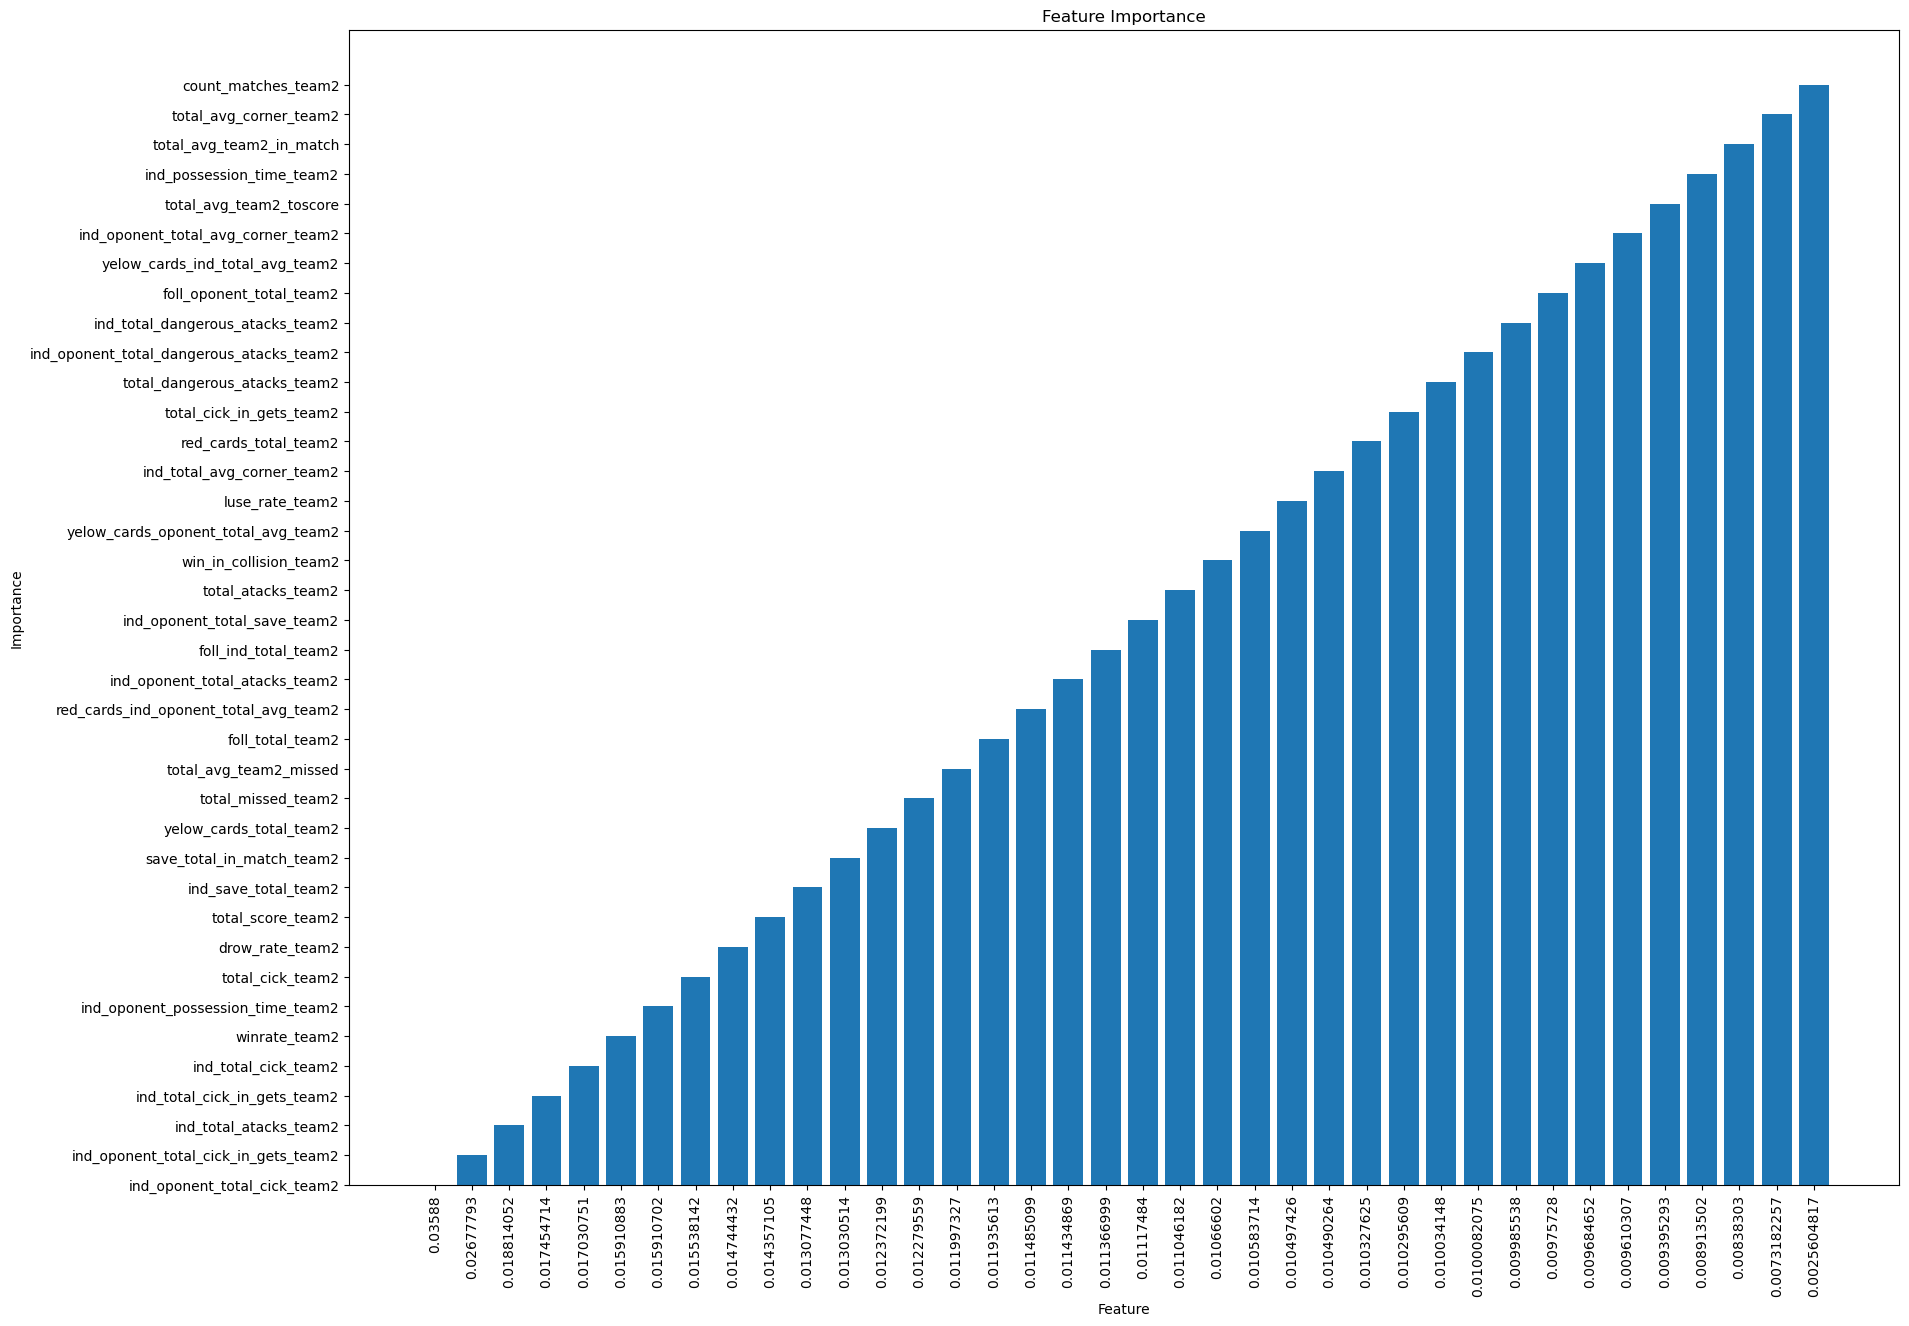

In [ ]:
plt.figure(figsize=(20, 15))
plt.bar(range(len(sorted_feature_importance2)), sorted_feature_importance2, align="center")
plt.xticks(range(len(sorted_feature_importance2)), sorted_feature_names2, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()